# Regresión LASSO

## 1. Importar paquetes y librerías

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import statsmodels.api as sm
import Curva
from statsmodels.graphics.api import abline_plot
from sklearn import datasets, linear_model
from sklearn.linear_model import LassoCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.metrics import r2_score, median_absolute_error,mean_squared_error
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.precision",3)
pd.set_option("display.max_rows",10)

## 2. Importar datos

In [2]:
loc=r"../interacciones_mensuales.csv"
data=pd.read_csv(loc,encoding="latin1",index_col=False,decimal=",",engine="python")
data = data.drop(data.columns[-20:], axis=1)

data=data[((data.Total-data.Total.mean()) / data.Total.std()).abs() <3]

### Identificación de hiper parámetros

In [5]:
X = data.drop(["Total","Year","Cod",'P_days'],axis=1) # Asignar variables independientes
nombres = data.drop(["Total","Year","Cod",'P_days'],axis=1).columns # Nombre de las variables dependientes
y = data['Total'] # Asignar variable dependiente

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

# Normalización de los atributos
scaler= preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

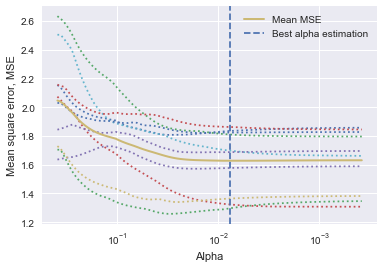

In [32]:
cacaoModel=LassoCV(cv=10,max_iter=2000).fit(X_train_scaled,y_train)

plt.figure()
plt.plot(cacaoModel.alphas_, cacaoModel.mse_path_,":")
plt.plot(cacaoModel.alphas_, cacaoModel.mse_path_.mean(axis=-1), label="Mean MSE",linewidth=2)
plt.axvline(cacaoModel.alpha_, linestyle="--", label="Best alpha estimation")
plt.semilogx()
plt.legend()
ax= plt.gca()
ax.invert_xaxis()
plt.xlabel("Alpha")
plt.ylabel("Mean square error, MSE")
plt.axis("tight");
#plt.savefig("Lasso-CV.jpg", dpi=600);

In [33]:
print("El valor de alpha que minimiza el error CV es: ", cacaoModel.alpha_)
print("Minímo MSE:", min(cacaoModel.mse_path_.mean(axis=-1)))

El valor de alpha que minimiza el error CV es:  0.007693496450125247
Minímo MSE: 1.6274773822285227


## 3. Ajuste y validación 

### Hold Out

In [36]:
R_2 = []
RMSE = []
MAE = []
CRM = []
pred = 0 
obs = 0

for i in range(100):
    
    X = data.drop(["Total","Year","Cod",'P_days'],axis=1) # Asignar variables independientes
    names = data.drop(["Total","Year","Cod",'P_days'],axis=1).columns # Nombre de las variables dependientes
    y = data['Total'] # Asignar variable dependiente
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

    scaler= preprocessing.StandardScaler().fit(X_train)
    X_train_scaled=scaler.transform(X_train)
    X_test_scaled=scaler.transform(X_test)
    
    cacaoLassoModel=linear_model.Lasso(alpha=cacaoModel.alpha_,max_iter=8000)
    cacaoLassoModel.fit(X_train_scaled,y_train)
    errorVector=y_test-cacaoLassoModel.predict(X_test_scaled)
    
    r_2=r2_score(y_test,cacaoLassoModel.predict(X_test_scaled))
    R_2.append(r_2)
    RMSE.append(np.linalg.norm((y_test-cacaoLassoModel.predict(X_test_scaled)),2)/np.sqrt(len(y_test)))
    MAE.append(median_absolute_error(y_test,cacaoLassoModel.predict(X_test_scaled)))
    CRM.append((sum(y_test)-sum(cacaoLassoModel.predict(X_test_scaled)))/sum(y_test))
    
    if r_2 >= max(R_2):
        model = cacaoLassoModel
        pred=cacaoLassoModel.predict(X_test_scaled)
        obs=y_test
        X_Test = X_test_scaled
        y_Test = y_test
        coef=pd.Series(cacaoLassoModel.coef_).sort_values(ascending=False)
        dic=dict()
        for i in list(coef.index):
            if names[i] not in dic:
                dic[names[i]]=coef[i]
            else:
                dic[names[i]]=1000
        pd.DataFrame(dic,index=["Coeficiente"]).T.to_csv("Coeficientes LASSO.csv",decimal=",")

In [37]:
print("R^2: %.4f" % np.mean(R_2))
print("RMSE: %.4f" % np.mean(RMSE))
print("MAE: %.4f" % np.mean(MAE))
print("CRM: %.4f" % (np.mean(CRM)))

R^2: 0.2066
RMSE: 1.2489
MAE: 0.9535
CRM: -0.0027


In [38]:
# Guardar los errores y el R^2
pd.DataFrame([R_2,MAE,RMSE],index=["R^2","MAE","RMSE"]).T.to_csv("Ajustes LASSO.csv",decimal=",")

## Curva de aprendizaje

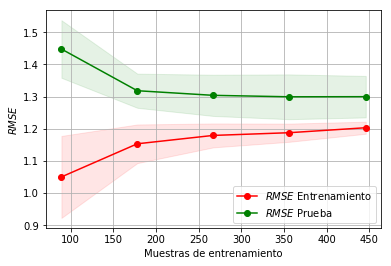

In [11]:
# Curva de aprendizaje

X=data.drop(["Total","Year","Cod",'P_days'],axis=1).values # Asignar variables independientes
y=data['Total'].values # Asignar variable dependiente

# Normalización de los atributos
scaler= preprocessing.StandardScaler().fit(X)
X_scaled=scaler.transform(X)

title = ""

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1706)
estimator = linear_model.Lasso(alpha=cacaoModel.alpha_,max_iter=8000)
Curva.plot_learning_curve(estimator, title, X_scaled, y, cv=cv, n_jobs=4)
plt.savefig("LC LASSO.jpg",dpi=600);

In [12]:
import seaborn as sns
sns.set()

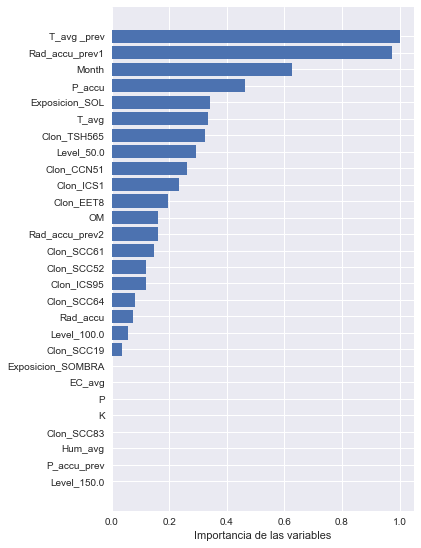

In [13]:
nombres = []
for i in np.abs(coef).sort_values().index:
    nombres.append(names[i])

featureImportance = np.abs(coef) / np.abs(coef).max()
sorted_idx = featureImportance.sort_values()
barPos = np.arange(sorted_idx.shape[0])
plt.barh(barPos, sorted_idx, align ="center")
plt.yticks(barPos,nombres)
plt.xlabel("Importancia de las variables")
plt.subplots_adjust(left=0.2,right=0.9,top=1.8,bottom=0.05)
plt.savefig("Variables_LASSO.jpg",dpi=600,bbox_inches="tight");

<Figure size 432x288 with 0 Axes>

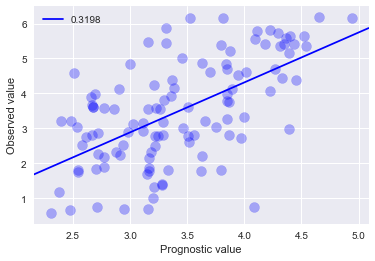

In [14]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 

plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Prognostic value")
plt.ylabel("Observed value")
plt.legend();

## 4. Evaluación de variables

## Importancia relativa de variables

In [15]:
predictores = X_test.columns
X_ = data.drop(["Total","Year","Cod",'P_days'],axis=1)
y = data['Total']

In [16]:
R_2 = []
RMSE = []
MAE = []

for i in predictores:
    
    X = X_.copy()
    X[i] = 0
    
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20, random_state= 0) #Hacer partición de datos en entrenamiento y prueba

    scaler= preprocessing.StandardScaler().fit(X_train)
    X_train_scaled=scaler.transform(X_train)
    X_test_scaled=scaler.transform(X_test)
    
    r_2=r2_score(y_test,model.predict(X_test_scaled))
    R_2.append(r_2)
    RMSE.append(np.linalg.norm((y_test-model.predict(X_test_scaled)),2)/np.sqrt(len(y_test)))
    MAE.append(median_absolute_error(y_test,model.predict(X_test_scaled)))

In [17]:
dic = {"R2":R_2,"RMSE":RMSE, "MAE":MAE}
DF = pd.DataFrame(dic,index=predictores)
DF["RI"] = RMSE/DF.RMSE.sum()
DF.sort_values(by = "RI",ascending=False,inplace = True)

## Estrategia de oscilación 

In [18]:
predictores = names
X_ = pd.DataFrame(X_Test,columns=names)
y = y_Test

In [19]:
var = ['T_avg','T_avg _prev',"P_accu", "P_accu_prev","Rad_accu","Rad_accu_prev1","Rad_accu_prev2","Hum_avg","EC_avg"]

In [19]:
R_2 = []
RMSE = []
MAE = []
pre = []
rango = []

for i in var:
    
    X = X_.copy()
    promedio = []
    
    for j in np.linspace(X[i].min(), X[i].max(),100):
        
        X[i] = j
        
        prediction = model.predict(X)

        r_2=r2_score(y,prediction)
        R_2.append(r_2)
        promedio.append(np.mean(prediction))
        pre.append(np.mean(prediction))
        RMSE.append(np.linalg.norm((y-prediction),2)/np.sqrt(len(y)))
        MAE.append(median_absolute_error(y,prediction))
        
    rango.append(max(promedio)-min(promedio))

In [20]:
dic = {}

for i in var:
    if i not in dic:
        dic[i] = np.linspace(X_[i].min(), X_[i].max(),100)

RMSE_1 = RMSE[:100]
RMSE_2 = RMSE[100:200]
RMSE_3 = RMSE[200:300]
RMSE_4 = RMSE[300:400]
RMSE_5 = RMSE[400:500]
RMSE_6 = RMSE[500:600]
RMSE_7 = RMSE[600:700]
RMSE_8 = RMSE[-100:]

PRE_1 = pre[:100]
PRE_2 = pre[100:200]
PRE_3 = pre[200:300]
PRE_4 = pre[300:400]
PRE_5 = pre[400:500]
PRE_6 = pre[500:600]
PRE_7 = pre[600:700]
PRE_8 = pre[-100:]

In [21]:
pde = pd.DataFrame(dic)
pde["RMSE_1"],pde["RMSE_2"],pde["RMSE_3"],pde["RMSE_4"],pde["RMSE_5"],pde["RMSE_6"],pde["RMSE_7"],pde["RMSE_8"] = RMSE_1,RMSE_2,RMSE_3,RMSE_4,RMSE_5,RMSE_6,RMSE_7,RMSE_8
pde["PRE_1"],pde["PRE_2"],pde["PRE_3"],pde["PRE_4"],pde["PRE_5"],pde["PRE_6"],pde["PRE_7"],pde["PRE_8"] = PRE_1,PRE_2,PRE_3,PRE_4,PRE_5,PRE_6,PRE_7,PRE_8
pde.to_csv("Evaluación_lasso.csv",decimal=",",index=False)

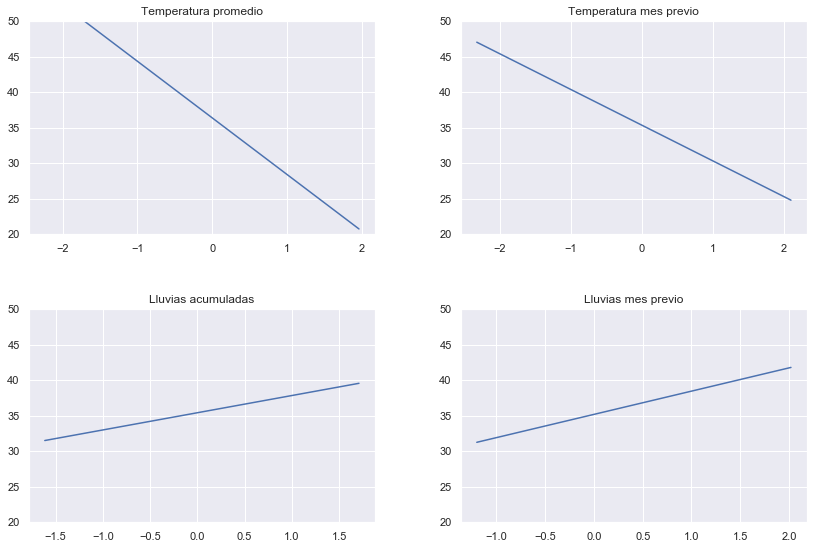

In [22]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.ylim(20,50)
plt.title("Temperatura promedio")
plt.plot(pde.T_avg,pde.PRE_1)

plt.subplot(2,2,2)
plt.ylim(20,50)
plt.title("Temperatura mes previo")
plt.plot(pde['T_avg _prev'],pde.PRE_2)

plt.subplot(2,2,3)
plt.ylim(20,50)
plt.title("Lluvias acumuladas")
plt.plot(pde.P_accu,pde.PRE_3)

plt.subplot(2,2,4)
plt.ylim(20,50)
plt.title("Lluvias mes previo")
plt.plot(pde.P_accu_prev,pde.PRE_4)

plt.subplots_adjust(top=0.92,bottom=0.05,left=0.05,right=0.95,
                   hspace=0.35,wspace=0.25)

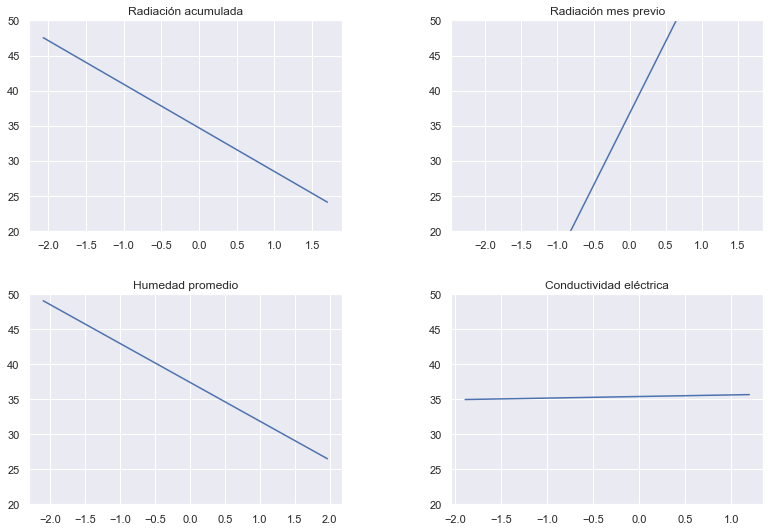

In [23]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.ylim(20,50)
plt.title("Radiación acumulada")
plt.plot(pde.Rad_accu,pde.PRE_5)

plt.subplot(2,2,2)
plt.ylim(20,50)
plt.title("Radiación mes previo")
plt.plot(pde.Rad_accu_prev1,pde.PRE_6)

plt.subplot(2,2,3)
plt.ylim(20,50)
plt.title("Humedad promedio")
plt.plot(pde.Hum_avg,pde.PRE_7)

plt.subplot(2,2,4)
plt.ylim(20,50)
plt.title("Conductividad eléctrica")
plt.plot(pde.EC_avg,pde.PRE_8)

plt.subplots_adjust(top=0.92,bottom=0.08,left=0.1,right=0.95,
                   hspace=0.3,wspace=0.35)

In [25]:
new_dic ={}
for i,j in enumerate(var):
    if j not in new_dic:
        new_dic[j]=round(rango[i]/sum(rango),2)

pd.DataFrame(new_dic,index=np.linspace(0,1,1))

,T_avg,T_avg _prev,P_accu,P_accu_prev,Rad_accu,Rad_accu_prev1,Rad_accu_prev2,Hum_avg,EC_avg
0.0,0.11,0.26,0.04,0.0,0.11,0.3,0.13,0.04,0.01
